In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys
from PIL import Image

## Load data

In [2]:
#masks = glob.glob("../input/graph_images/train/label/*.png")
masks = np.load('../input/graph_images/train/label/adjcouput_matrix.npy',allow_pickle='TRUE').item()

orgs = glob.glob("../input/graph_images/train/image/*.png")

In [3]:
imgs_list = []
masks_list = []
for image, mask in zip(orgs, masks):


    imgs_list.append(np.array(Image.open(image).convert('L').resize((512,512))))
    #print(image)
    key = image
    #print(key[-14:-9])
    graph_label = masks[key[-14:-9]]


    masks_list.append(np.array(graph_label))

imgs_np = np.asarray(imgs_list)

masks_np = np.asarray(masks_list)
y_positions_label = masks_np[:,:,0:2]
y_adjacency_label = masks_np[:,:,2:37]



y_label = [y_positions_label,y_adjacency_label]
print(y_positions_label.shape)
print(y_adjacency_label.shape)

(100, 35, 2)
(100, 35, 35)


In [4]:
print(imgs_np.shape, y_label[0].shape, y_label[1].shape )

(100, 512, 512) (100, 35, 2) (100, 35, 35)


## Plot images + masks + overlay (mask over original)

In [5]:
from keras_unet.utils import plot_imgs

#plot_imgs(org_imgs=imgs_np, mask_imgs=masks_np, nm_img_to_plot=10, figsize=6)


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


## Get data into correct shape, dtype and range (0.0-1.0)

In [6]:
print(imgs_np.max(), masks_np.max())

255 1.0


In [7]:
x = np.asarray(imgs_np, dtype=np.float32)/255
#y = np.asarray(masks_np, dtype=np.float32)/255


In [8]:

#y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)

layer_dim_node_positions = 512
layer_dim_adjacency = 50



print(y_label[0].shape)


y_label_positions = y_label[0]
y_label_adjacency = y_label[1]

y_label_positions  = y_label_positions.reshape((y_label_positions.shape[0],y_label_positions.shape[1]*2))
y_label_adjacency = y_label_adjacency.reshape((y_label_adjacency.shape[0],y_label_adjacency.shape[1],y_label_adjacency.shape[2],1))
print(y_label_adjacency.shape)
#y_label_adjacency = y_label[1].reshape(y_label[1].shape[0], y_label[1].shape[1], y_label[1].shape[2], 1)

a = np.full((y_label_positions.shape[0],layer_dim_node_positions), -9.9)
b = np.zeros((y_label[1].shape[0],layer_dim_adjacency,layer_dim_adjacency ,1))


print(b.shape)
#y_label_adjacency = y_label[1].reshape(y_label[1].shape[0], y_label[1].shape[1], y_label[1].shape[2], 1)

a[:,0:y_label_positions.shape[1]] = y_label_positions
b[:,0:y_label_adjacency.shape[1],0:y_label_adjacency.shape[2],:]= y_label_adjacency
print(b.shape)




y_label = [a, b]




625

(100, 35, 2)
(100, 35, 35, 1)
(100, 50, 50, 1)
(100, 50, 50, 1)


625

In [9]:
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)


##  Train/val split

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train_positions,y_val_positions, y_train_adjacency, y_val_adjacency = train_test_split(x, y_label[0], y_label[1], test_size=0.5, random_state=0)
print("x_train: ", x_train.shape)
print("y_train_positions: ", y_train_positions.shape)
print(" y_train_adjacency: ", y_train_adjacency.shape)
print("x_val: ", x_val.shape)
print("y_val_positions: ", y_val_positions.shape)
print("y_val_adjacency: ", y_val_adjacency.shape)

from models_graph.prepare_functions import convert_to_tensor
x_train = convert_to_tensor(x_train)
x_val = convert_to_tensor(x_val)
y_train_positions = convert_to_tensor(y_train_positions)

y_train_adjacency = convert_to_tensor(y_train_adjacency)
y_val_positions = convert_to_tensor(y_val_positions)
y_val_adjacency = convert_to_tensor(y_val_adjacency)




x_train:  (50, 512, 512, 1)
y_train_positions:  (50, 512)
 y_train_adjacency:  (50, 50, 50, 1)
x_val:  (50, 512, 512, 1)
y_val_positions:  (50, 512)
y_val_adjacency:  (50, 50, 50, 1)


## Initialize network

In [11]:
# from keras_unet.models import custom_unet
#
input_shape = x_train[0].shape
#
# model = custom_unet(
#     input_shape,
#     upsample_mode="deconv",  # 'deconv' or 'simple'
#     use_batch_norm=False,
#     num_classes=1,
#     filters=64,
#     dropout=0.2,
#     output_activation='relu'
# )

In [12]:
#model.summary()

In [13]:
# currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
# parentdir = os.path.dirname(currentdir)
# sys.path.insert(0, parentdir)

#from models_graph import *
from models_graph.custom_graph_head2 import custom_graph_head, custom_adj_unet

print(input_shape)
model = custom_adj_unet(input_size = input_shape, pretrained_weights =None)


(512, 512, 1)


In [14]:

print(model.output_shape)
print(model.output_shape[0][1])

[(None, 512), (None, 50, 50)]
512


In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         input_image[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [16]:
import os
os.environ["PATH"] += os.pathsep + "C:\\Program Files\\Graphviz\\bin\\"

In [17]:
import sys
print(sys.path)

sys.path.append("C:\\Program Files\\Graphviz\\bin\\")

print(sys.path)

['C:\\Users\\Schüle\\git\\LearnGraphExtraction\\keras-unet\\notebooks', 'C:\\Users\\Schüle\\git\\LearnGraphExtraction', 'C:\\Users\\Schüle\\AppData\\Local\\Programs\\Python\\Python37\\Lib', 'c:\\users\\schüle\\appdata\\local\\programs\\python\\python37\\python37.zip', 'C:\\Users\\Schüle\\AppData\\Local\\Programs\\Python\\Python37\\DLLs', 'c:\\users\\schüle\\appdata\\local\\programs\\python\\python37', '', 'C:\\Users\\Schüle\\AppData\\Roaming\\Python\\Python37\\site-packages', 'C:\\Users\\Schüle\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages', 'C:\\Users\\Schüle\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages\\deepwalk-1.0.3-py3.7.egg', 'c:\\users\\schüle\\git\\labelme', 'c:\\users\\schüle\\git\\learngraphextraction\\keras-unet', 'C:\\Users\\Schüle\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages\\win32', 'C:\\Users\\Schüle\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Schüle\\AppData\\Local\\Pro

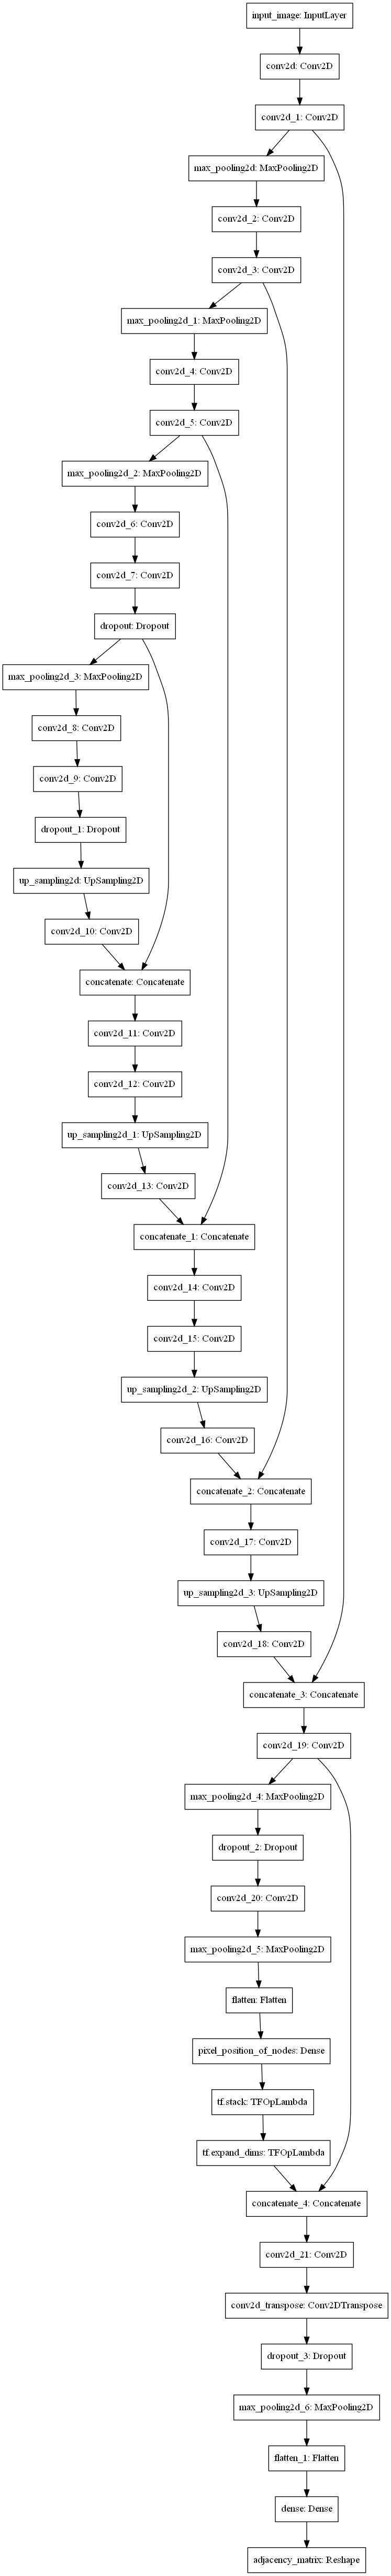

In [18]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

## Compile + train

In [19]:
# from keras.callbacks import ModelCheckpoint
#
#
# model_filename = 'segm_model_v0.h5'
# callback_checkpoint = ModelCheckpoint(
#     model_filename,
#     verbose=1,
#     monitor='val_loss',
#     save_best_only=True,
# )

In [20]:
# model.compile(
#     optimizer=keras.optimizers.RMSprop(1e-3),
#     loss={
#         "pixel position of nodes": keras.losses.MeanSquaredError(),
#         "adjacency matrix":  keras.losses.BinaryCrossentropy(from_logits=True),
#     },
#     loss_weights=[1.0, 0.2],
# )
import keras
from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from models_graph.losses import loss_node_positions
from models_graph.losses import loss_adjacency

# model.compile(
#      optimizer=keras.optimizers.RMSprop(1e-3),
#      loss={
#          "pixel_position_of_nodes": loss_node_positions,
#          "adjacency_matrix":  loss_adjacency,
#      },
#      loss_weights=[1.0, 0.2],
#  )

model.compile(
   optimizer=keras.optimizers.RMSprop(1e-3),
   loss={
       "pixel_position_of_nodes": keras.losses.MeanSquaredError(),
       "adjacency_matrix":   keras.losses.BinaryCrossentropy(),
   },
   loss_weights=[1.0, 0.2],
)
print('done')

done


In [ ]:

from models_graph.losses import loss_node_positions
from models_graph.losses import loss_adjacency

#
# model.fit({'input_image': x_train},{'pixel_position_of_nodes': y_train_positions, 'adjacency_matrix': y_train_adjacency},
#           epochs = 1, batch_size=2 ,
#           validation_data=({'input_image': x_val},{'pixel_position_of_nodes': y_val_positions, 'adjacency_matrix': y_val_adjacency}),
#         )
#
print(y_train_adjacency.shape)
print(y_train_positions.shape)
model.fit(x_train, [y_train_positions, y_train_adjacency],
          epochs = 1, batch_size=2 ,
           )

#model.fit(x= x_train,y=[y_train_positions, y_train_adjacency] , epochs=10)


(50, 50, 50, 1)
(50, 512)
 1/25 [>.............................] - ETA: 13:12 - loss: 121.6772 - pixel_position_of_nodes_loss: 120.2464 - adjacency_matrix_loss: 7.1543

## Plot training history

In [ ]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

## Plot original + ground truth + pred + overlay (pred on top of original)

In [ ]:
model.load_weights(model_filename)
y_pred = model.predict(x_val)

In [ ]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=9)